In [1]:
hindsight_results_dir = "~/hindsight-results/application_microbenchmark"
application_latency_throughput_nocompute = "%s/application_latency_throughput_nocompute" % hindsight_results_dir
application_latency_throughput = "%s/application_latency_throughput" % hindsight_results_dir
application_throughputs = "%s/application_throughputs" % hindsight_results_dir
application_headsampling = "%s/application_headsampling" % hindsight_results_dir
application_headsampling_nocompute = "%s/application_headsampling_nocompute" % hindsight_results_dir


Max attained throughput w/ closed-loop workload
hindsight-0.0: 73671
hindsight-0.01: 72212
hindsight-0.1: 68459
hindsight-1.0: 66147
none-0.0: 76355
ot-jaeger-0.0: 75375
ot-jaeger-0.01: 72422
ot-jaeger-0.1: 64006
ot-jaeger-1.0: 33139


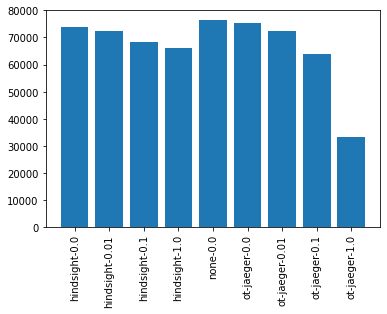

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("%s/summary2.csv" % application_throughputs)

df["samplerate"] = df["samplerate"].astype(str)
df['label'] = df[["tracer", "samplerate"]].agg('-'.join, axis=1)


closed_tputs = df[df.workload == "closedloop"][["label", "throughput", "throughput2"]].groupby("label").max()
throughputs = dict(zip(closed_tputs.index.values, closed_tputs["throughput2"].values))

print("Max attained throughput w/ closed-loop workload")
for label, throughput in throughputs.items():
  print("%s: %d" % (label, throughput))



fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(closed_tputs.index.values, closed_tputs["throughput2"].values)
plt.xticks(rotation=90)
plt.show()

Request rates: 1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000
hindsight-0.0: 23104
hindsight-0.01: 23111
hindsight-0.1: 22855
hindsight-1.0: 21895
none-0.0: 24082
ot-jaeger-0.0: 23537
ot-jaeger-0.01: 23223
ot-jaeger-0.1: 22204
ot-jaeger-1.0: 16432


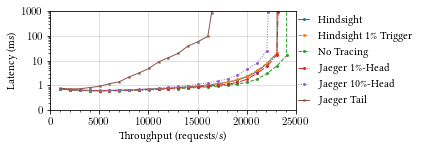

In [84]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


rc_fonts = {
    "font.family": "serif",
    "font.size": 11,
    'figure.figsize': (6, 2.2),
    "text.usetex": True,
    'text.latex.preview': True,
    'text.latex.preamble': [
        r"""
        \usepackage[libertine]{newtxmath}
        \usepackage{libertine}
        """],
}
matplotlib.rcParams.update(rc_fonts)


df = pd.read_csv("%s/summary2.csv" % application_latency_throughput)

df["samplerate"] = df["samplerate"].astype(str)
df['label'] = df[["tracer", "samplerate"]].agg('-'.join, axis=1)

openloops = df[df.workload == "openloop"]

# idx = openloops.groupby(["label", "requests"])['latency'].transform(max) == openloops['latency']
# maxes = openloops[idx]
# grouped_df = maxes.groupby("label")

print("Request rates: %s" % ",".join([str(v) for v in sorted(list(openloops["requests"].unique()))]))

grouped_df = openloops.groupby(["label", "requests"])[["latency", "throughput", "throughput2"]].median().groupby(["label"])

all = []
for key, item in grouped_df:
    g = grouped_df.get_group(key).sort_values("requests")
    g = g[g["latency"] <= 1000]
    max_throughput = g["throughput"].max()
    series = {
      "name": key,
      "x": list(g["throughput"]) + [max_throughput],
      "y": list(g["latency"]) + [2000]
    }
    all.append(series)
    print("%s: %d" % (key, g["throughput"].max()))

fig = plt.figure(figsize=(6,2.2))
ax1 = fig.add_subplot(111)
ax1.set_yscale("log")
ax1.grid(visible=True, which='major', axis='both', alpha=0.5)
ax1.set_ylim([0.1, 1000])
ax1.set_xlim([0,25000])
ax1.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.xaxis.set_minor_locator(MultipleLocator(1000))
ax1.xaxis.set_major_locator(MultipleLocator(5000))
# ax1.set_xscale("log")
# ax1.set_ylim([0.1, 1000])
ax1.set_xlabel("Throughput (requests/s)")
ax1.set_ylabel("Latency (ms)")

# show = ["none-0.0", "hindsight-0.0", "hindsight-0.01", "ot-jaeger-1.0", "ot-jaeger-0.01", "ot-jaeger-0.1"]
labels = {
  "none-0.0": "No Tracing",
  "hindsight-0.0": "Hindsight",
  "hindsight-0.01": "Hindsight 1\% Trigger",
  # "hindsight-0.1": "Hindsight 10% Trigger",
  # "hindsight-1.0": "Hindsight 100% Trigger",
  "ot-jaeger-1.0": "Jaeger Tail",
  "ot-jaeger-0.01": "Jaeger 1\%-Head",
  "ot-jaeger-0.1": "Jaeger 10\%-Head"
}

from itertools import cycle
lines = ["-","--","--","-.",":"]
linecycler = cycle(lines)
points = ['o','o','o','o','o','x']
pointcycler = cycle(points)
sizes = [2]
sizecycler = cycle(sizes)

for series in all:
  if series["name"] in labels:
    ax1.plot(series["x"], series["y"], marker = next(pointcycler), ls=next(linecycler), label=labels[series["name"]], linewidth=1, markersize=next(sizecycler), alpha=1)


# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), frameon=False, handlelength=1)

plt.tight_layout()
plt.savefig("throughput_compute.pdf",bbox_inches='tight')
plt.show()

# 1000, 2000, 4000, 8000, 12000
# 32,128,320,1280
# 32,64,128,256,

Request rates: 2000,4000,6000,8000,10000,12000,14000,16000,18000,20000,22000,24000,26000,28000,30000,32000,34000,36000,38000,40000,42000,44000,46000,48000,50000,52000,54000,56000,58000,60000,62000,64000,66000,68000,70000,72000,74000,76000,78000,80000
hindsight-0.0: 70359
hindsight-0.01: 69236
hindsight-0.1: 66328
hindsight-1.0: 64271
none-0.0: 70994
ot-jaeger-0.0: 71335
ot-jaeger-0.01: 70239
ot-jaeger-0.1: 63516
ot-jaeger-1.0: 41423


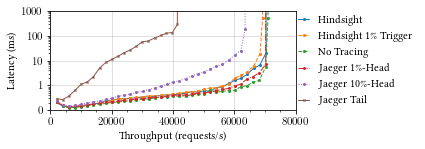

In [83]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


rc_fonts = {
    "font.family": "serif",
    "font.size": 11,
    'figure.figsize': (6, 2.2),
    "text.usetex": True,
    'text.latex.preview': True,
    'text.latex.preamble': [
        r"""
        \usepackage[libertine]{newtxmath}
        \usepackage{libertine}
        """],
}
matplotlib.rcParams.update(rc_fonts)


df = pd.read_csv("%s/summary2.csv" % application_latency_throughput_nocompute)

df["samplerate"] = df["samplerate"].astype(str)
df['label'] = df[["tracer", "samplerate"]].agg('-'.join, axis=1)

openloops = df[df.workload == "openloop"]

# idx = openloops.groupby(["label", "requests"])['latency'].transform(max) == openloops['latency']
# maxes = openloops[idx]
# grouped_df = maxes.groupby("label")

print("Request rates: %s" % ",".join([str(v) for v in sorted(list(openloops["requests"].unique()))]))

grouped_df = openloops.groupby(["label", "requests"])[["latency", "throughput", "throughput2"]].median().groupby(["label"])

all = []
for key, item in grouped_df:
    g = grouped_df.get_group(key).sort_values("requests")
    g = g[g["latency"] <= 1000]
    max_throughput = g["throughput"].max()
    series = {
      "name": key,
      "x": list(g["throughput"]) + [max_throughput],
      "y": list(g["latency"]) + [2000]
    }
    all.append(series)
    print("%s: %d" % (key, g["throughput"].max()))

fig = plt.figure(figsize=(6,2.2))
ax1 = fig.add_subplot(111)
ax1.set_yscale("log")
ax1.grid(visible=True, which='major', axis='both', alpha=0.5)
ax1.set_ylim([0.1, 1000])
ax1.set_xlim([0,80000])
ax1.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.xaxis.set_minor_locator(MultipleLocator(5000))
ax1.xaxis.set_major_locator(MultipleLocator(20000))
# ax1.set_xscale("log")
# ax1.set_ylim([0.1, 1000])
ax1.set_xlabel("Throughput (requests/s)")
ax1.set_ylabel("Latency (ms)")

# show = ["none-0.0", "hindsight-0.0", "hindsight-0.01", "ot-jaeger-1.0", "ot-jaeger-0.01", "ot-jaeger-0.1"]
labels = {
  "none-0.0": "No Tracing",
  "hindsight-0.0": "Hindsight",
  "hindsight-0.01": "Hindsight 1\% Trigger",
  # "hindsight-0.1": "Hindsight 10% Trigger",
  # "hindsight-1.0": "Hindsight 100% Trigger",
  "ot-jaeger-1.0": "Jaeger Tail",
  "ot-jaeger-0.01": "Jaeger 1\%-Head",
  "ot-jaeger-0.1": "Jaeger 10\%-Head"
}

from itertools import cycle
lines = ["-","--","--","-.",":"]
linecycler = cycle(lines)
points = ['o','o','o','o','o','x']
pointcycler = cycle(points)
sizes = [2]
sizecycler = cycle(sizes)

for series in all:
  if series["name"] in labels:
    ax1.plot(series["x"], series["y"], marker = next(pointcycler), ls=next(linecycler), label=labels[series["name"]], linewidth=1, markersize=next(sizecycler), alpha=1)


# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), frameon=False, handlelength=1)

plt.tight_layout()
plt.savefig("throughput.pdf",bbox_inches='tight')
plt.show()

# 1000, 2000, 4000, 8000, 12000
# 32,128,320,1280
# 32,64,128,256,

Sample rates: 0.0,0.00125,0.0025,0.005,0.01,0.025,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
hindsight throughput: 72218 (95.77%)
none throughput: 75412


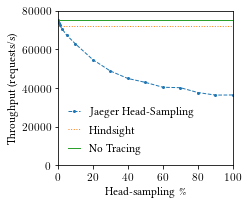

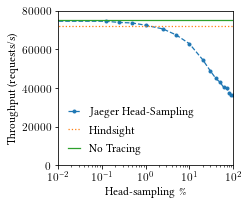

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


rc_fonts = {
    "font.family": "serif",
    "font.size": 11,
    'figure.figsize': (3,2.5),
    "text.usetex": True,
    'text.latex.preview': True,
    'text.latex.preamble': [
        r"""
        \usepackage[libertine]{newtxmath}
        \usepackage{libertine}
        """],
}
matplotlib.rcParams.update(rc_fonts)

df = pd.read_csv("%s/summary2.csv" % application_headsampling_nocompute)

df["sampleratelabel"] = df["samplerate"].astype(str)
df['label'] = df[["tracer", "sampleratelabel"]].agg('-'.join, axis=1)


closed_tputs = df[df.workload == "closedloop"][["label", "tracer", "samplerate", "throughput", "throughput2"]].groupby(["label", "tracer", "samplerate"]).mean()
closed_tputs = closed_tputs.reset_index()
print("Sample rates: %s" % ",".join([str(v) for v in sorted(list(closed_tputs["samplerate"].unique()))]))


xs = [100 * v for v in list(closed_tputs[closed_tputs["tracer"] == "ot-jaeger"]["samplerate"])]

all = []
all.append({
  "name": "ot-jaeger",
  "x": xs,
  "y": list(closed_tputs[closed_tputs["tracer"] == "ot-jaeger"]["throughput2"])
})

others = ["hindsight", "none"]
other_throughputs = dict()
for tracer in others:
  if tracer in list(closed_tputs["tracer"].unique()):
    tput = list(closed_tputs[closed_tputs["tracer"] == tracer]["throughput2"])[0]
    other_throughputs[tracer] = tput
    all.append({
      "name": tracer,
      "x": xs,
      "y": [tput] * len(xs)
    })
  else:
    print("No data for %s" % tracer)

if "none" in other_throughputs:
  for tracer, tput in other_throughputs.items():
    if tracer != "none":
      print("%s throughput: %d (%.2f%%)" % (tracer, tput, 100 * tput / float(other_throughputs["none"])))
    else:
      print("%s throughput: %d" % (tracer, tput))
else:
  for tracer, tput in other_throughputs.items():
    print("%s throughput: %d" % (tracer, tput))


from itertools import cycle
lines = ["--",":","-"]
linecycler = cycle(lines)
points = ["o","",""]
pointcycler = cycle(points)
sizes = [2]
sizecycler = cycle(sizes)


fig = plt.figure()
ax1 = fig.add_subplot(111)
# ax1.set_yscale("log")
ax1.set_ylim([0, 80000])
# ax1.set_xscale("log")
ax1.set_xlim([0.0,100])
ax1.set_xlabel("Head-sampling \%")
ax1.set_ylabel("Throughput (requests/s)")
# ax1.set_ylim([0.1, 1000])

labels = {
  "none": "No Tracing",
  "hindsight": "Hindsight",
  "ot-jaeger": "Jaeger Head-Sampling",
}

for series in all:
    ax1.plot(series["x"], series["y"],marker = next(pointcycler), markersize=2, ls=next(linecycler), linewidth=1,label=labels[series["name"]])
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("headsampling.pdf",bbox_inches='tight')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
# ax1.set_yscale("log")
ax1.set_ylim([0, 80000])
ax1.set_xscale("log")
ax1.set_xlim([0.1,100])
ax1.set_xlabel("Head-sampling \%")
ax1.set_ylabel("Throughput (requests/s)")

linecycler = cycle(lines)
pointcycler = cycle(points)
for series in all:
    ax1.plot(series["x"], series["y"],marker = next(pointcycler), markersize=3, ls=next(linecycler),linewidth=1.25,label=labels[series["name"]])
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("headsampling_logscale.pdf",bbox_inches='tight')
plt.show()

Sample rates: 0.0,0.00125,0.0025,0.005,0.01,0.025,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
hindsight throughput: 21670 (95.64%)
none throughput: 22659


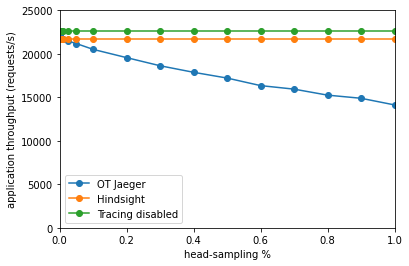

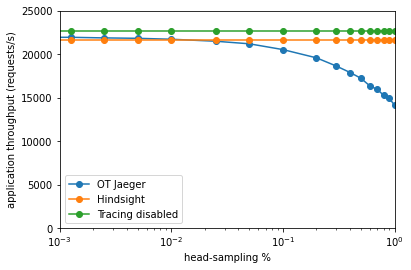

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("%s/summary2.csv" % application_headsampling)

df["sampleratelabel"] = df["samplerate"].astype(str)
df['label'] = df[["tracer", "sampleratelabel"]].agg('-'.join, axis=1)


closed_tputs = df[df.workload == "closedloop"][["label", "tracer", "samplerate", "throughput", "throughput2"]].groupby(["label", "tracer", "samplerate"]).mean()
closed_tputs = closed_tputs.reset_index()
print("Sample rates: %s" % ",".join([str(v) for v in sorted(list(closed_tputs["samplerate"].unique()))]))


xs = list(closed_tputs[closed_tputs["tracer"] == "ot-jaeger"]["samplerate"])

all = []
all.append({
  "name": "ot-jaeger",
  "x": xs,
  "y": list(closed_tputs[closed_tputs["tracer"] == "ot-jaeger"]["throughput2"])
})

others = ["hindsight", "none"]
other_throughputs = dict()
for tracer in others:
  if tracer in list(closed_tputs["tracer"].unique()):
    tput = list(closed_tputs[closed_tputs["tracer"] == tracer]["throughput2"])[0]
    other_throughputs[tracer] = tput
    all.append({
      "name": tracer,
      "x": xs,
      "y": [tput] * len(xs)
    })
  else:
    print("No data for %s" % tracer)

if "none" in other_throughputs:
  for tracer, tput in other_throughputs.items():
    if tracer != "none":
      print("%s throughput: %d (%.2f%%)" % (tracer, tput, 100 * tput / float(other_throughputs["none"])))
    else:
      print("%s throughput: %d" % (tracer, tput))
else:
  for tracer, tput in other_throughputs.items():
    print("%s throughput: %d" % (tracer, tput))


fig = plt.figure()
ax1 = fig.add_subplot(111)
# ax1.set_yscale("log")
ax1.set_ylim([0, 25000])
# ax1.set_xscale("log")
ax1.set_xlim([0.0,1])
ax1.set_xlabel("head-sampling %")
ax1.set_ylabel("application throughput (requests/s)")
# ax1.set_ylim([0.1, 1000])

labels = {
  "none": "Tracing disabled",
  "hindsight": "Hindsight",
  "ot-jaeger": "OT Jaeger",
}

for series in all:
    ax1.plot(series["x"], series["y"],marker = 'o', label=labels[series["name"]])
plt.legend()
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
# ax1.set_yscale("log")
ax1.set_ylim([0, 25000])
ax1.set_xscale("log")
ax1.set_xlim([0.001,1])
ax1.set_xlabel("head-sampling %")
ax1.set_ylabel("application throughput (requests/s)")

for series in all:
    ax1.plot(series["x"], series["y"],marker = 'o', label=labels[series["name"]])
plt.legend()
plt.show()